# TensorFlow Implementaton of Laplace Approximation for GP Hyperparameters (w/ Internal Newton Optimiser)
This is an example python script to illustrate LA GP fitting with TensorFlow

## Step 1: Read in summarised TRaC data with matched covariates and build as TensorFlow constants 

- Age restricted to 1-50 y/o (to limit impact of maternal anti-bodies and limit look-back time)

- Sites snapped to land-sea mask boundary and standardised covariates extracted

- Area including Port-au-Prince and surrounds excluded (to limit impact of migration) 

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
from scipy.io import mmread
import osgeo.gdal as gdal
import os
import matplotlib.pyplot as plt
import pickle

# Start a tensorflow session
sess = tf.Session(config = tf.ConfigProto())
sess.run(tf.global_variables_initializer())

# Import the trac data
tracdata = pd.read_csv('../trac_data/summary_TRaC_data_with_covariates.csv')

# Village positions
village_lats = tracdata.groupby(['Cluster_Num'])['Latitude'].unique().values
village_longs = tracdata.groupby(['Cluster_Num'])['Longitude'].unique().values

# Number of villages
Nvillages = tracdata.Cluster_Num.unique().size

# Extract the titres and ages for all individuals, grouped by village
titres = tf.constant(np.log(np.abs(tracdata.AMA.values + 30)), dtype='float32')
ages = tf.constant(tracdata.Age.values, dtype='float32')
cluster_assignments = tf.constant(tracdata.Cluster_Num.values, dtype='int32')

# Number of individuals
Nindividuals = len(tracdata.Age.values)

# Extract the mean covariates in each cell
covariates = tracdata.groupby(['Cluster_Num'])['covariate_accessibility','covariate_AI','covariate_distTowater','covariate_elevation','covariate_forest','covariate_grass','covariate_urbanbarren','covariate_woodysavanna','covariate_OSM','covariate_PET','covariate_slope','covariate_TWI'].mean().values
covariates = tf.constant(covariates, dtype='float32')

# Number of covariates
Ncovariates = covariates.shape[1]

In [2]:
# Load in the batch normalizations for re-scaling inputs to the neural likelihood
f = open('simulations/simulations/model_2/batch_normalizations.pkl', 'rb')
xs_mean, xs_std, ps_mean, ps_std = pickle.load(f)
f.close()

# Data = individual titres re-scaled by batch norms for input to the neural likelihood
data_individual = (tf.expand_dims(titres,1)-xs_mean)/ xs_std

In [3]:
# Read in matrices for INLA mesh projections

# Projection from INLA grid to cluster locations
Amatrix = mmread('data/A_matrix.mtx')

# Size of INLA grid
Nmesh = Amatrix.shape[1]

# The various bits of the SPDE precision matrix (on the INLA grid)
M0 = mmread('data/M0_matrix.mtx')
M1 = mmread('data/M1_matrix.mtx')
M2 = mmread('data/M2_matrix.mtx')

# Cast to tf constants
Amatrix = tf.constant(Amatrix.toarray(), dtype='float32') # Not sure if it's worth figuring out how to use SparseTensors
M0 = tf.constant(M0.toarray(), dtype='float32')
M1 = tf.constant(M1.toarray(), dtype='float32')
M2 = tf.constant(M2.toarray(), dtype='float32')

# Matrix to project INLA triangular grid to the full resolution of the covariates
Afullmatrix = mmread('data/Afull_matrix.mtx')
Afullmatrix = Afullmatrix.toarray()

In [4]:
# GP hyper-parameter kappa
log_kappa = tf.Variable(1.0, dtype ='float32')
prior_log_kappa = tfp.distributions.Normal(loc = 0.0, scale = 1.0)
log_tau = tf.Variable(-3.0, dtype = 'float32')
prior_log_tau = tfp.distributions.Normal(loc = 0.0, scale = 1.0)

# Set-up GP for the log-field
log_field = tf.Variable(np.zeros(Nmesh), dtype='float32')
spde_prec = (tf.exp(log_kappa*4.0)*M0 + tf.constant(2.0, dtype ='float32')*tf.exp(log_kappa*2.0)*M1 + M2)*tf.exp(log_tau*tf.constant(2.0,dtype = 'float32'))
spde_cov = tf.matrix_inverse(spde_prec)
prior_log_field = tfp.distributions.MultivariateNormalFullCovariance(loc = tf.constant(np.zeros(Nmesh), dtype='float32'), covariance_matrix = spde_cov)

# Slopes and intercept for linear predictor part of the model
slopes = tf.Variable(np.zeros(Ncovariates), dtype='float32')
prior_slopes = tfp.distributions.Normal(loc = 0.0, scale = 1.0)
intercept = tf.Variable(0.0, dtype='float32')
prior_intercept = tfp.distributions.Normal(loc = 0.0, scale = 5.0)

# Serology hyper-parameters
serology = tf.Variable(np.array([
                          np.log(0.5), # logHetExp
                          0.25, # fzero
                          20, # azero
                          np.log(0.5), # logHetBoosting
                          9, # baselineBoostingFactor
                          np.log(8), # logBaseineBoostingThreshold
                          np.log(1), # logAttenuationFactor
                          12,# ageAdultAntibodies
                          np.log(1), # logRhoChild
                          np.log(3), # logRhoAdult
                          5, # mean background antibody levels
                          np.log(10), # log std dev antibody background level
                          ]), dtype='float32')

# Serology prior
serology_lower = tf.constant(np.array([
                          np.log(0.05), # logHetExp
                          0, # fzero
                          10, # azero
                          np.log(0.05), # logHetBoosting
                          6, # baselineBoostingFactor
                          np.log(4), # logBaseineBoostingThreshold
                          np.log(0.05), # logAttenuationFactor
                          5,# ageAdultAntibodies
                          np.log(0.1), # logRhoChild
                          np.log(0.1), # logRhoAdult
                          -5, # mean background antibody levels
                          np.log(1), # log std dev antibody background level
                          ]), dtype='float32')

serology_upper = tf.constant(np.array([
                          np.log(1), # logHetExp
                          0.5, # fzero
                          30, # azero
                          np.log(1), # logHetBoosting
                          12, # baselineBoostingFactor
                          np.log(12), # logBaseineBoostingThreshold
                          np.log(2), # logAttenuationFactor
                          20,# ageAdultAntibodies
                          np.log(5), # logRhoChild
                          np.log(40), # logRhoAdult ### log(40) for MSP and AMA, log(10) for LSA ###
                          15, # mean background antibody levels
                          np.log(20), # log std dev antibody background level
                          ]), dtype='float32')

prior_serology = tfp.distributions.Uniform(low=serology_lower, high=serology_upper)

# Additional prior on the maximum infection rate: only trained the NDE upto a certain value
prior_linear_predictor = tfp.distributions.Uniform(low=tf.constant(-1e10, dtype='float32'), high=tf.constant(np.log(10), dtype='float32'))

In [5]:
# Set-up for the neural density estimator:
# read in weights and biases, set the architecture (to same as the trained NDE)

# Load in the network weights and biases
f = open('simulations/simulations/model_2/network_weights.pkl', 'rb')
network_weights = pickle.load(f)
f.close()
f = open('simulations/simulations/model_2/network_biases.pkl', 'rb')
network_biases = pickle.load(f)
f.close()

# Declare weights and biases as tf.constants
weights = [tf.constant(network_weights[0], dtype='float32'), tf.constant(network_weights[1], dtype='float32')]
biases = [tf.constant(network_biases[0], dtype='float32'), tf.constant(network_biases[1], dtype='float32')]

# (Global) set-up parameters for the NDE
n_antibodies = 1 # number of antibodies
n_parameters = 12 + 1 # serology + log_eir
D = n_antibodies # size of data (number of antibodies)
P = n_parameters + 1 # number of parameters (num serology parameters + EIR + age)
M = 10 # number of Gaussian components
N = int((D + D * (D + 1) / 2 + 1)*M)
n_hidden = [100,100]
activations = [tf.tanh, tf.tanh]

# Functions for mapping the neural network output to the mixture model components

# Build lower triangular matrices (parameterizing the covariances) from network output (also calculate determinant)
def lower_triangular_matrix(σ):
    Σ = []
    det = []
    start = 0
    end = 1
    for i in range(D):
        exp_val = tf.exp(σ[:, :, end-1])
        det.append(exp_val)
        if i > 0:
            Σ.append(tf.pad(tf.concat([σ[:, :, start:end-1], tf.expand_dims(exp_val, -1)], -1), [[0, 0], [0, 0], [0, D-i-1]]))
        else:
            Σ.append(tf.pad(tf.expand_dims(exp_val, -1), [[0, 0], [0, 0], [0, D-i-1]]))
        start = end
        end += i + 2
    Σ = tf.transpose(tf.stack(Σ), (1, 2, 0, 3))
    det = tf.reduce_prod(tf.stack(det), 0)
    return Σ, det

# Split network output into component means, covariances and weights (also returns determinant of covariance)
def mapping(output_layer, M, D):
    μ, Σ, α = tf.split(output_layer, [M * D, M * D * (D + 1) // 2, M], 1)
    μ = tf.reshape(μ, (-1, M, D))
    Σ, det = lower_triangular_matrix(tf.reshape(Σ, (-1, M, D * (D + 1) // 2)))
    α = tf.nn.softmax(α)
    return μ, Σ, α, det

In [6]:
##### NOTE: Cell below constructs log posterior for use outside the Newton optimization while_loop()
##### Skip this if you want everything done inside the Newton optimizer

In [7]:
# Construct log posterior here for use outside the Newton optimization while_loop()

# Convert log field to tensor
#log_field = tf.convert_to_tensor(log_field)

# Linear predictor model for EIR: GP + C\beta + \beta_0
linear_predictor = tf.squeeze(tf.matmul(Amatrix,tf.expand_dims(log_field,1))) + intercept + tf.squeeze(tf.matmul(covariates,tf.expand_dims(slopes,1)))

# Set up the parameters vector: list of (lambda_EIR, serology_parameters, age) for each individual
# NOTE: neural likelihood currently trained on EIR, NOT log(EIR), hence the exp() -- this will change on the next run
theta = (tf.concat([tf.expand_dims(tf.gather(linear_predictor, cluster_assignments-1),1), # EIR at the individuals locations
                                tf.transpose(tf.tile(tf.reshape(serology, [-1,1]), [1,Nindividuals])), # Shared serology parameters for all individuals
                                tf.expand_dims(ages,1)], axis=1) - ps_mean)/ ps_std # Ages, and then shift and re-scale everything according to the batch normalization for the neural likelihood

# Log prior over hyper-parameters and log-field (GP)
log_prior = prior_log_kappa.log_prob(log_kappa) \
+ prior_log_tau.log_prob(log_tau) \
+ prior_log_field.log_prob(log_field) \
+ tf.reduce_sum(prior_slopes.log_prob(slopes)) \
+ prior_intercept.log_prob(intercept) \
+ tf.reduce_sum(prior_serology.log_prob(serology)) \
+ tf.reduce_sum(prior_linear_predictor.log_prob(linear_predictor)) # extra prior over the linear predictor to make sure it stays within the range of the trained NDE

# Set up the NDE likelihood

# Build the layers of the network

# First layer (input) is just the parameters
layers = [theta] 

# Now loop through the hidden layers
for i in range(len(n_hidden)):
    if i < len(n_hidden) - 1:
        layers.append(activations[i](tf.add(tf.matmul(layers[i], weights[i]), biases[i])))
    else:
        layers.append(tf.add(tf.matmul(layers[i], weights[i]), biases[i]))

# Map the output layer to mixture model parameters
μ, Σ, α, det = mapping(layers[-1], M, D)

# Compute the log likelihood
log_likelihood = tf.reduce_sum(tf.log(tf.reduce_sum(tf.exp(-0.5*tf.reduce_sum(tf.square(tf.einsum("ijlk,ijk->ijl", Σ, tf.subtract(tf.expand_dims(data_individual, 1), μ))), 2) + tf.log(α) + tf.log(det) - D*np.log(2. * np.pi) / 2.), 1) + 1e-37))

# Log prior over hyper-parameters and log-field (GP)
log_prior = prior_log_kappa.log_prob(log_kappa) \
+ prior_log_tau.log_prob(log_tau) \
+ prior_log_field.log_prob(log_field) \
+ tf.reduce_sum(prior_slopes.log_prob(slopes)) \
+ prior_intercept.log_prob(intercept) \
+ tf.reduce_sum(prior_serology.log_prob(serology)) \
#+ tf.reduce_sum(prior_linear_predictor.log_prob(linear_predictor)) # extra prior over the linear predictor to make sure it stays within the range of the trained NDE

# Negative log posterior
negative_log_posterior_prob = -(log_likelihood + log_prior)

In [8]:
# Test the gradients and hessian for the log posterior
# NOTE: getting a lot of zeros in the gradients and hessian, expected?
sess.run(tf.global_variables_initializer())
print(sess.run(negative_log_posterior_prob))
print(sess.run(tf.gradients(negative_log_posterior_prob, log_field)))
print(sess.run(tf.hessians(negative_log_posterior_prob, log_field)))

13108.531
[array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.96323578e+02,
       1.47083069e+02, 1.00472153e+02, 8.41484833e+01, 8.90565186e+01,
       1.34108612e+02, 2.22411530e+02, 1.42249756e+02, 7.96238174e+01,
       8.05265198e+01, 6.81661835e+01, 6.28338089e+01, 1.06631355e

In [9]:
# Try to just to an adam optimize of the whole thing
optimiser = tf.train.AdagradOptimizer(1e-3) # Behaviour sensitive to this training rate!
train = optimiser.minimize(negative_log_posterior_prob, var_list = [log_field, log_kappa, log_tau, slopes, intercept, serology])

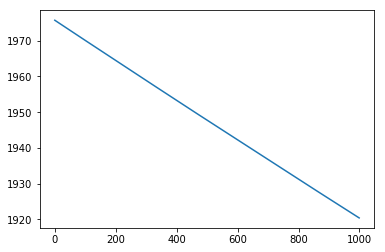

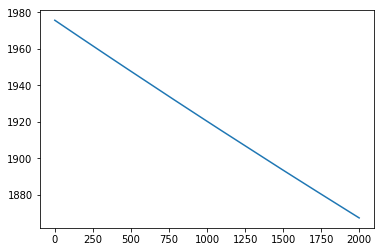

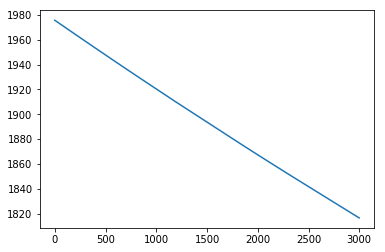

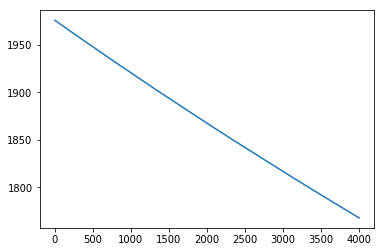

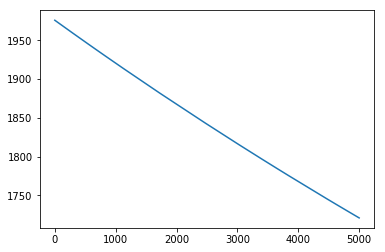

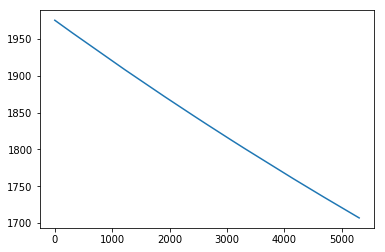

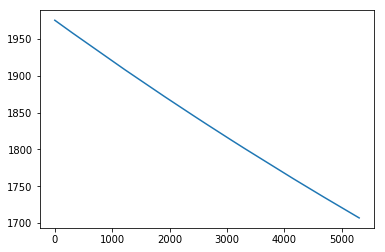

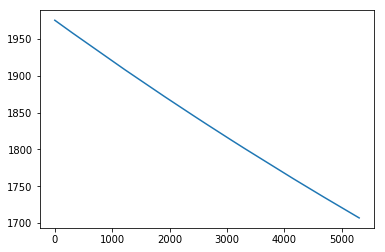

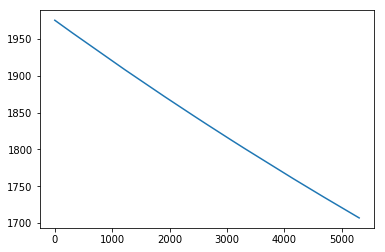

In [14]:
#sess.run(tf.global_variables_initializer())
nepochs = 10000
neg_log_pdf = np.zeros(nepochs)
for i in range(nepochs):
    sess.run(train)
    neg_log_pdf[i] = sess.run(negative_log_posterior_prob)
    if i % 1000 == 0 and i > 0:
        plt.plot(neg_log_pdf[0:i])
        plt.show()

In [6]:
# Newton optimization iteration to optimize p(z | \theta, x) for fixed \theta and data x and find laplace approximation for it
def inner_vector_update(log_field, iter_diff, log_laplace_approximation, output_collections=(), name=None):
    
    # Convert log field to tensor
    log_field = tf.convert_to_tensor(log_field)
    
    # Linear predictor model for EIR: GP + C\beta + \beta_0
    linear_predictor = tf.squeeze(tf.matmul(Amatrix,tf.expand_dims(log_field,1))) + intercept + tf.squeeze(tf.matmul(covariates,tf.expand_dims(slopes,1)))

    # Set up the parameters vector: list of (lambda_EIR, serology_parameters, age) for each individual
    theta = (tf.concat([tf.expand_dims(tf.gather(linear_predictor, cluster_assignments-1),1), 
                                    tf.transpose(tf.tile(tf.reshape(serology, [-1,1]), [1,Nindividuals])), 
                                    tf.expand_dims(ages,1)], axis=1) - ps_mean)/ ps_std
    
    # Log prior over hyper-parameters and log-field (GP)
    log_prior = prior_log_kappa.log_prob(log_kappa) \
    + prior_log_tau.log_prob(log_tau) \
    + prior_log_field.log_prob(log_field) \
    + tf.reduce_sum(prior_slopes.log_prob(slopes)) \
    + prior_intercept.log_prob(intercept) \
    + tf.reduce_sum(prior_serology.log_prob(serology)) \
    + tf.reduce_sum(prior_linear_predictor.log_prob(linear_predictor)) # extra prior over the linear predictor to make sure it stays within the range of the trained NDE
    
    # Set up the NDE likelihood

    # Build the layers of the network
    
    # First layer (input) is just the parameters
    layers = [theta] 

    # Now loop through the hidden layers
    for i in range(len(n_hidden)):
        if i < len(n_hidden) - 1:
            layers.append(activations[i](tf.add(tf.matmul(layers[i], weights[i]), biases[i])))
        else:
            layers.append(tf.add(tf.matmul(layers[i], weights[i]), biases[i]))

    # Map the output layer to mixture model parameters
    μ, Σ, α, det = mapping(layers[-1], M, D)

    # Compute the log likelihood
    log_likelihood = tf.reduce_sum(tf.log(tf.reduce_sum(tf.exp(-0.5*tf.reduce_sum(tf.square(tf.einsum("ijlk,ijk->ijl", Σ, tf.subtract(tf.expand_dims(data_individual, 1), μ))), 2) + tf.log(α) + tf.log(det) - D*np.log(2. * np.pi) / 2.), 1) + 1e-37))
    
    # Negative log posterior
    negative_log_posterior_prob = -(log_likelihood + log_prior)

    # Do a Newton step towards the optimal log-field and record difference
    new_log_field = log_field - tf.constant(0.5, dtype = 'float32')*tf.squeeze(tf.matmul(tf.squeeze(tf.matrix_inverse(tf.hessians(negative_log_posterior_prob,log_field))),tf.expand_dims(tf.squeeze(tf.gradients(negative_log_posterior_prob,log_field)),1)))
    new_iter_diff = tf.reduce_sum(tf.abs(log_field-new_log_field))
  
    # New laplace approximation for p(z | \theta, x)
    new_log_laplace_approximation = tf.constant(Nmesh*0.9189385, dtype = 'float32') - tf.constant(0.5, dtype = 'float32')*tf.linalg.logdet(tf.squeeze(tf.hessians(negative_log_posterior_prob,log_field))) - negative_log_posterior_prob
        
    return [new_log_field, new_iter_diff, new_log_laplace_approximation]

# Convergence criterion for the Newton optimizer
def running_condition(log_field,iter_diff,log_laplace_approximation, output_collections=(), name=None):
    return tf.greater(iter_diff,tf.constant(0.001, dtype = 'float32')) 

# Initialize log laplace approximation and convergence criterion test
log_laplace_approximation = tf.constant(0.0, dtype = 'float32')
iter_diff = tf.constant(100000000000000000000.0, dtype = 'float32')

# Do the Newton optimization for fixed \theta
iteration_outputs = tf.while_loop(running_condition,inner_vector_update,[log_field,iter_diff,log_laplace_approximation])

# log laplace approximation for p(z | \theta, x) evaluated at the mode z_*, and corresponding mode z_*
log_laplace_approx_at_conditional_mode = iteration_outputs[2]
log_field_at_conditional_mode = iteration_outputs[0]

# Set up the optimizer to find MAP hyper parameters
optimiser = tf.train.AdagradOptimizer(0.05) # Behaviour sensitive to this training rate!
train = optimiser.minimize(-log_laplace_approx_at_conditional_mode, var_list = [log_kappa, log_tau, slopes, intercept, serology])

In [7]:
# Test the newton optimizer with the current hyper-parameters
sess.run(tf.global_variables_initializer())
sess.run(iteration_outputs)

[array([-1.6640753 , -2.5601163 , -2.7671826 , -2.274752  , -2.5726936 ,
        -1.9312786 , -1.4574317 , -1.2376482 , -3.4472866 , -2.1735246 ,
        -1.449919  , -1.4850017 , -1.8750013 , -2.66414   , -1.6471913 ,
        -1.2908758 , -1.7787113 , -2.4605691 , -1.9019362 , -2.0773687 ,
        -1.8229811 , -2.7437313 , -2.7499735 , -3.142415  , -1.90661   ,
        -2.9646356 , -1.9925734 , -1.1971501 , -2.0795033 , -2.3252869 ,
        -3.3381054 , -1.9036347 , -2.8692381 , -2.1092405 , -2.9932594 ,
        -2.7513368 , -1.9382454 , -1.5481589 , -2.017346  , -2.671078  ,
        -2.3185863 , -2.249017  , -2.3866315 , -3.266153  , -4.277514  ,
        -3.3124268 , -2.618866  , -2.4900115 , -3.3182497 , -3.7168539 ,
        -3.7172313 , -2.2178054 , -2.1185226 , -1.5296483 , -2.570377  ,
        -2.80674   , -3.0931425 , -2.8638387 , -2.7282252 , -3.219773  ,
        -2.92779   , -1.6430484 , -4.239279  , -3.870586  , -4.003503  ,
        -3.8188682 , -3.3678331 , -3.6018255 , -3.7

In [ ]:
# Run the optimizer to find hyper-parameters
sess.run(tf.global_variables_initializer())
sess.run(train)
sess.run(train)

# Initialize hyper-parameters and stopping criterion
log_kappa_diff = 1000.0 # This is not a sophisticated stopping criterion!
old_log_kappa = sess.run(log_kappa)

# Keep training until convergence criterion satisfied
while (log_kappa_diff > 0.01):
    sess.run(train)
    log_kappa_diff = np.abs(sess.run(log_kappa)-old_log_kappa) 
    old_log_kappa = sess.run(log_kappa)
    print(log_kappa_diff)

In [ ]:
# Pull out the log-field at the conditional mode with the empirical Bayes hyper-parameters
log_field = sess.run(log_field_at_conditional_mode)
slopes = sess.run(slopes)
intercept = sess.run(intercept)

# Full resolution covariates
covariatesfull = pd.read_csv('data/fullcovariates.csv').values[:,1:13]

# Evaluate the high-resolution EIR
linear_predictor = np.matmul(Afullmatrix,log_field) + np.matmul(covariatesfull,slopes) + intercept

In [ ]:
# Plot the recovered EIR map

# Load in the full resolution covariates tif
ds = gdal.Open('data/covariates_AI.tif')
covariate = ds.GetRasterBand(1)
nodata = covariate.GetNoDataValue()
referenceimage = covariate.ReadAsArray()
referenceimage = np.ma.masked_less(referenceimage,-3)

# Sort out the mask
valid_pixels = referenceimage.mask==0
valid_pixels_indices = np.nonzero(np.ndarray.flatten(valid_pixels)) # row-major flattening
n_valid_pixels = np.sum(valid_pixels)

# Get the lats/longs for the pixel values in the rasters
x0, dx, dxdy, y0, dydx, dy = ds.GetGeoTransform()
nrows, ncols = referenceimage.shape
lonarray = np.linspace(x0, x0+dx*ncols, ncols)
latarray = np.linspace(y0, y0+dy*nrows, nrows)
pixel_longs, pixel_lats = np.meshgrid(lonarray, latarray)

# Create image with the inferred EIR
referenceimage.put(np.where(np.ndarray.flatten(referenceimage.mask)==0),linear_predictor)

# Plot it!
plt.scatter(village_longs, village_lats, c='red', s = 1) # check image coordinate transforms by comparing raster plot against observation locations 
imgplot = plt.imshow(referenceimage,extent=[np.min(pixel_longs),np.max(pixel_longs),np.min(pixel_lats),np.max(pixel_lats)])
plt.xlim(np.min(pixel_longs[valid_pixels]),np.max(pixel_longs[valid_pixels]))
plt.ylim(np.min(pixel_lats[valid_pixels]),np.max(pixel_lats[valid_pixels]))
#plt.colorbar()
plt.show()